In [2]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
train = pd.read_csv("labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
test = pd.read_csv("testData.tsv", header=0, delimiter="\t", quoting=3)

train.review[0]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

In [3]:
def preprocessor(review):
    return BeautifulSoup(review, 'html5lib').get_text()

analyzer = CountVectorizer().build_analyzer()
stemmer = EnglishStemmer()

def stem_analyzer(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

In [4]:
count_v = CountVectorizer(analyzer=stem_analyzer, preprocessor=preprocessor, stop_words='english', max_features=5000)
tfidf_v = TfidfVectorizer(analyzer=stem_analyzer, preprocessor=preprocessor, stop_words='english', max_features=5000)

In [5]:
# try
sentences = ["I eat an apple pie and he eats two apple pies", 'I have a cat and he has two cats']
_count_test = count_v.fit_transform(sentences)
_tfidf_test = tfidf_v.fit_transform(sentences)

print (count_v.get_feature_names())
print (tfidf_v.get_feature_names())

print (_count_test.toarray())
print (_tfidf_test.toarray())

['an', 'and', 'appl', 'cat', 'eat', 'has', 'have', 'he', 'pie', 'two']
['an', 'and', 'appl', 'cat', 'eat', 'has', 'have', 'he', 'pie', 'two']
[[1 1 2 0 2 0 0 1 2 1]
 [0 1 0 2 0 1 1 1 0 1]]
[[ 0.2624434   0.18673064  0.5248868   0.          0.5248868   0.          0.
   0.18673064  0.5248868   0.18673064]
 [ 0.          0.25948224  0.          0.72938646  0.          0.36469323
   0.36469323  0.25948224  0.          0.25948224]]


In [7]:
train_reviews = set([r for r in train.review])
test_reviews = set([r for r in test.review])

In [8]:
# once fit on train, then transform on train and test
count_v.fit(train_reviews)
X_all_count_v = count_v.transform(train_reviews).toarray()
X_test_count_v = count_v.transform(test_reviews).toarray()

tfidf_v.fit(train_reviews)
X_all_tfidf_v = tfidf_v.transform(train_reviews).toarray()
X_test_tfidf_v = tfidf_v.transform(test_reviews).toarray()

y_all = train.sentiment

In [9]:
np.savez_compressed("local_count_vectorized_data.npz", X_all=X_all_count_v, X_test=X_test_count_v, y_all = y_all)
np.savez_compressed("local_tfidf_vectorized_data.npz", X_all=X_all_tfidf_v, X_test=X_test_tfidf_v, y_all = y_all)

# Train

In [16]:
SIZE = 2000
data = np.load('local_count_vectorized_data.npz')
X_all, X_test, y_all = data['X_all'][:SIZE], data['X_test'][:SIZE], data['y_all'][:SIZE]

In [17]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from scikitplot import plotters as skplt

X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.33)

rfc = LogisticRegression()
rfc.fit(X_train, y_train)
y_proba = rfc.predict_proba(X_val)
y_pred = rfc.predict(X_val)

cross_val_score(LogisticRegression(), X_all, y_all)

array([ 0.81437126,  0.83783784,  0.78978979])

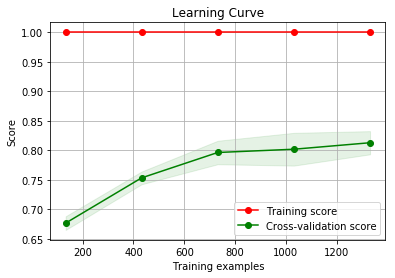

In [18]:
skplt.plot_learning_curve(LogisticRegression(), X_all, y_all)
plt.show()

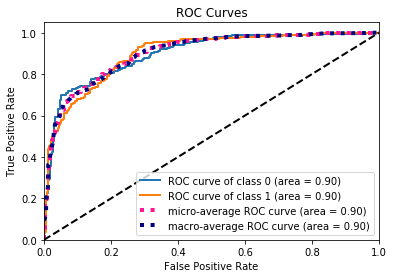

In [19]:
skplt.plot_roc_curve(y_true=y_val, y_probas=y_proba)
plt.show()

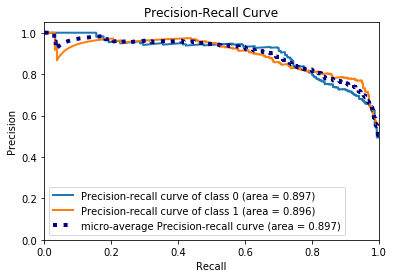

In [20]:
skplt.plot_precision_recall_curve(y_true=y_val, y_probas=y_proba)
plt.show()

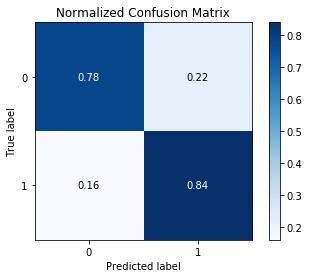

In [21]:
skplt.plot_confusion_matrix(y_true=y_val, y_pred=y_pred, normalize=True)
plt.show()